In [33]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [34]:
# Create a Spark session
spark = SparkSession.builder.appName("MachineLearning").getOrCreate()
# Load the data into a DataFrame
train_data = spark.read.csv("Train_data.csv", header=True, inferSchema=True, sep=",")
test_data = spark.read.csv("Test_data.csv", header=True, inferSchema=True, sep=",")

In [35]:
train_data.show(5)

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rat

In [36]:
test_data.show(5)

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_coun

In [37]:
train_data.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [38]:
test_data.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [39]:
train_data.describe().show()

+-------+------------------+-------------+-------+-----+------------------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------+
|summary|          duration|protocol_type|service| flag|         src_bytes|         dst_bytes|                land|      wrong_fragment|              urgent|    

In [40]:
test_data.describe().show()

+-------+------------------+-------------+-------+-----+------------------+------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+
|summary|          duration|protocol_type|service| flag|         src_bytes|         dst_bytes|                land|      wrong_fragment|            urgent|                hot

In [41]:

# Define the function for label encoding
def le(df):
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns if df.schema[column].dataType == StringType()]
    for indexer in indexers:
        df = indexer.transform(df).drop(indexer.getInputCol())
    return df

# Apply the function to your DataFrames
train_data = le(train_data)
test_data = le(test_data)

# Drop the 'num_outbound_cmds' column from both DataFrames
train_data = train_data.drop('num_outbound_cmds')
test_data = test_data.drop('num_outbound_cmds')

In [42]:
train_data.show(5)

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------------+-------------+----------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_count|dst_host_srv_count|dst_h

In [43]:
feature_columns = [col for col in train_data.columns if col != 'type_of_attack_index']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create the random forest classifier instance.
rfc = RandomForestClassifier(labelCol='type_of_attack_index', featuresCol='features', maxBins=70)

# Chain the assembler and the random forest classifier in a Pipeline
pipeline = Pipeline(stages=[assembler, rfc])

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Feature importance is given by the Random Forest model
rfModel = model.stages[-1]
feature_importances = rfModel.featureImportances.toArray()

# Map feature importance values to the column names
feature_map = [(feature, importance) for feature, importance in zip(feature_columns, feature_importances)]

# Sort the features by importance
sorted_features = sorted(feature_map, key=lambda x: x[1], reverse=True)

# Select the top n features you want to keep
n_features_to_select = 10
selected_features = [feature for feature, _ in sorted_features[:n_features_to_select]]

# Now we create a new assembler for the reduced feature set
assembler = VectorAssembler(inputCols=selected_features, outputCol="selected_features")

# Transform the train data to include the new feature vector with selected features
X_train_reduced = assembler.transform(train_data).select('selected_features')

# Show the selected features
selected_features

['src_bytes',
 'dst_bytes',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_diff_srv_rate',
 'service_index',
 'logged_in',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'serror_rate']

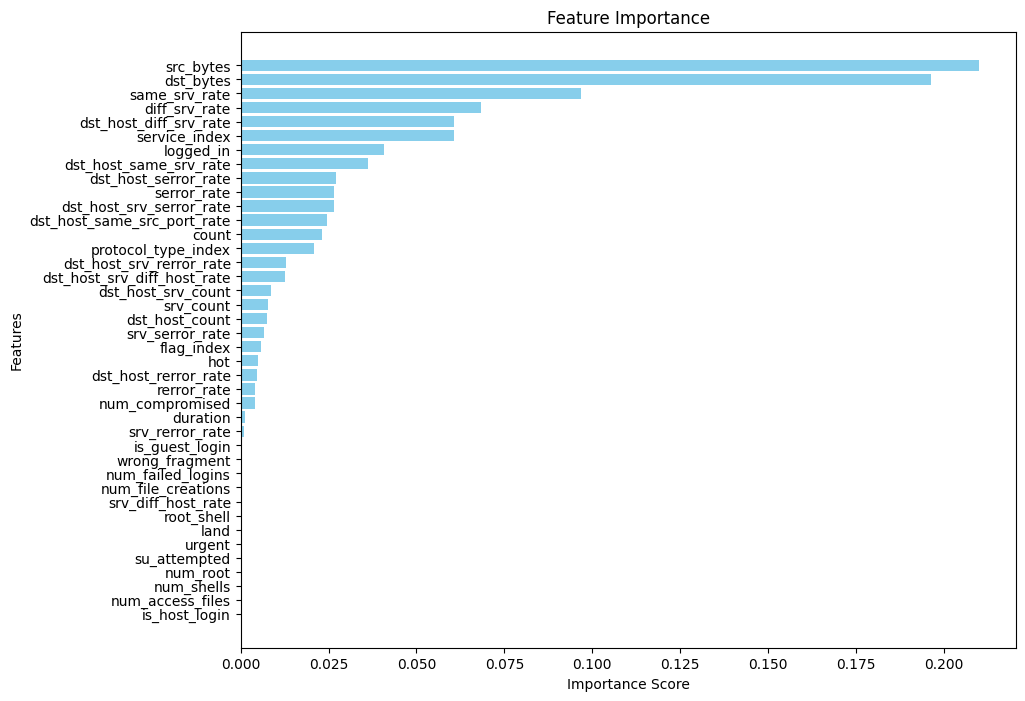

In [44]:
import matplotlib.pyplot as plt

# Assuming `feature_map` is a list of tuples where the first element is the feature name
# and the second element is the feature importance
sorted_features = sorted(feature_map, key=lambda x: x[1], reverse=True)

# Unzip the feature names and their importance scores
features, importances = zip(*sorted_features)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [45]:
(train_data_split, test_data_split) = train_data.randomSplit([0.7, 0.3], seed=42)

# Create a new assembler for the reduced feature set
assembler_reduced = VectorAssembler(inputCols=selected_features, outputCol="features")

# Create the random forest classifier instance using the reduced feature set.
rfc_reduced = RandomForestClassifier(labelCol='type_of_attack_index', featuresCol='features', maxBins=70)

# Chain the assembler and the random forest classifier in a Pipeline
pipeline_reduced = Pipeline(stages=[assembler_reduced, rfc_reduced])

# Fit the pipeline to the training data split
model_reduced = pipeline_reduced.fit(train_data_split)

# Make predictions on the training and test data
predictions_train = model_reduced.transform(train_data_split)
predictions_test = model_reduced.transform(test_data_split)

# Create an evaluator for the classifier's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="type_of_attack_index", predictionCol="prediction", metricName="accuracy")

# Calculate the training and test accuracy
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

# Print the training and testing scores
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Testing Accuracy: {accuracy_test:.4f}")

Training Accuracy: 0.9896
Testing Accuracy: 0.9863


Area under ROC: 0.9992


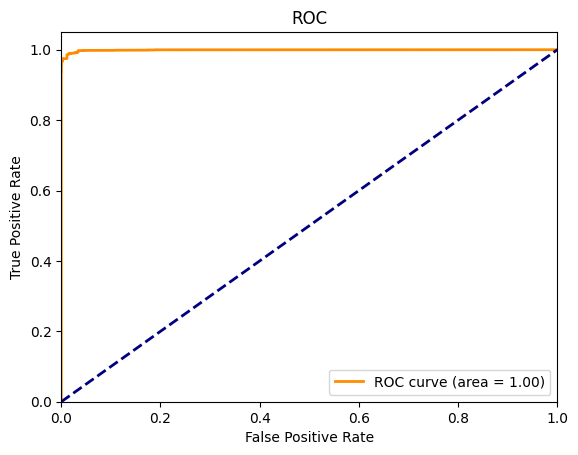

In [46]:
# Make sure to use the test data here to evaluate the model's performance on unseen data
predictions = model_reduced.transform(test_data_split)

# Create a BinaryClassificationEvaluator and specify the metric as "areaUnderROC"
evaluator = BinaryClassificationEvaluator(labelCol='type_of_attack_index', rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Compute the area under the ROC curve
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC: {roc_auc:.4f}")

# Retrieve the probability of the positive class (assuming binary classification)
results = predictions.select(['probability', 'type_of_attack_index'])

# Prepare score-and-labels for ROC metrics
results_collect = results.collect()
score_and_labels = [(float(i.probability[1]), float(i.type_of_attack_index)) for i in results_collect]

# Spark MLLib doesn't provide direct ROC plotting functionality, so we'll need to use sklearn to plot the ROC curve
from sklearn.metrics import roc_curve, auc

# Separate the score and labels
scores = [s[0] for s in score_and_labels]
labels = [s[1] for s in score_and_labels]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# model_path = "model_reduced"
# # Save the trained model to the defined path
# model_reduced.write().save(model_path)